# Feature Selection, Dimentionality reduction and model development

This notebooks contains code for data processing, feature selection and multiple model fitting and evaluation using california housing dataset 


In [1]:
# Import necessary libraries and functions
from sklearn.datasets import fetch_california_housing
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression, SelectPercentile, SelectKBest
from sklearn.feature_selection import f_regression

## Data processing

In [2]:
# data formating
housing = fetch_california_housing(as_frame= True) # access the data 
print(housing.DESCR) # print the description of the dataset

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [3]:
# prepare labels and features   
x = housing['data']
y = housing['target']
feature_names = housing['feature_names']

## Supervied feature selection

Function to evaluate at every step of feature selection to select the best feature using Linear Regression

In [4]:
def checkFS(new_x, x, y, model):
    # split the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
    # fit the model
    model.fit(x_train, y_train)
    # predict the model
    y_pred = model.predict(x_test)
    # calculate the r2 score
    r2 = r2_score(y_test, y_pred)
    # calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    # print the r2 score and mean squared error
    print(f"R2 score: {r2}")
    print(f"Mean Squared Error: {mse}")
    x_train, x_test, y_train, y_test = train_test_split(new_x, y, test_size=0.2, random_state=42)
    # fit the model with the new x
    model.fit(x_train, y_train)
    # predict the model with the new x
    y_pred = model.predict(x_test)
    # calculate the r2 score with the new x
    r2_new = r2_score(y_test, y_pred)
    # calculate the mean squared error with the new x
    mse_new = mean_squared_error(y_test, y_pred)
    # print the r2 score and mean squared error with the new x
    print(f"R2 score with new x: {r2_new}")
    print(f"Mean Squared Error with new x: {mse_new}")

### Selecting features using mutual info regression

Visualize the dependency score of each features for better selection

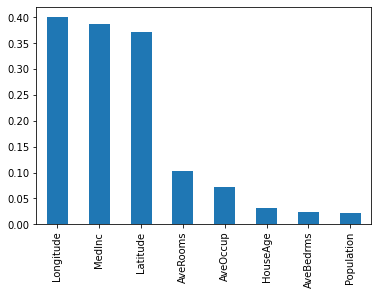

In [5]:
# mutual_info_regression based selection of features
mi = mutual_info_regression(x, y)
mi = pd.Series(mi)
mi.index = feature_names
mi = mi.sort_values(ascending=False)
mi.plot.bar()
plt.show()

Select the top 5 features of data and run linear regression model to evaluate the performance

In [6]:
x_mi = SelectPercentile(mutual_info_regression, percentile=60).fit(x, y)
selected_features_mask = x_mi.get_support()
selected_features = x.columns[selected_features_mask].tolist()
print("Selected Features:", selected_features)

Selected Features: ['MedInc', 'AveRooms', 'AveOccup', 'Latitude', 'Longitude']


Subset the x with selected features

In [7]:
# subset x using mutual_info_regression
x_mi = SelectPercentile(mutual_info_regression, percentile=60).fit_transform(x, y)

Comparasion of subset dataset with original dataset

In [8]:
# Check the score
checkFS(x_mi, x, y, LinearRegression())

R2 score: 0.575787706032451
Mean Squared Error: 0.5558915986952441
R2 score with new x: 0.5732648513884984
Mean Squared Error with new x: 0.5591975700714763


### Selecting features using f_regression

Visualize the dependency score of each features for better selection

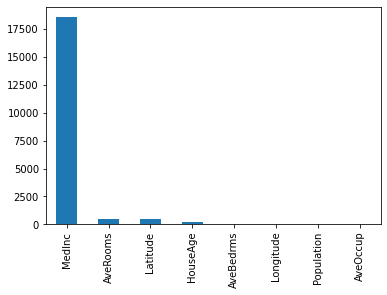

In [9]:
# mutual_info_regression based selection of features
mi = f_regression(x, y)
mi = pd.Series(mi[0])
mi.index = feature_names
mi = mi.sort_values(ascending=False)
mi.plot.bar()
plt.show()

Subset x with the best selected features

In [10]:
x_f = SelectKBest(f_regression, k=4 ).fit_transform(x, y)

Comparasion of f_regression subset x with original x

In [11]:
# Check the score
checkFS(x_f, x, y, LinearRegression())

R2 score: 0.575787706032451
Mean Squared Error: 0.5558915986952441
R2 score with new x: 0.5043169272470043
Mean Squared Error with new x: 0.6495475488975627


### Pearson Correlation - feature selection

<AxesSubplot:>

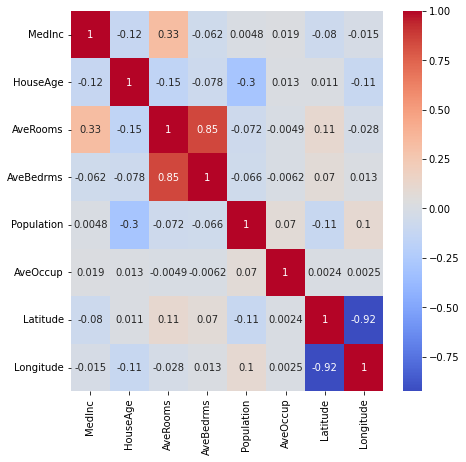

In [12]:
# correlation between features
x_df = pd.DataFrame(x, columns=housing['feature_names'])
y_df = pd.DataFrame(y, columns=['target'])
df = pd.concat([x_df, y_df], axis=1)
correlation = df.corr()
plt.figure(figsize=(7, 7))
sns.heatmap(correlation, annot=True, cmap='coolwarm')

In [14]:
# variance of longitude, latitude ,Average Rooms  and Average Bedrooms
print("Longitude variance:", x_df['Longitude'].var())
print("Latitude variance:", x_df['Latitude'].var())
print("Average Rooms variance:", x_df['AveRooms'].var())
print("Average Bedrooms variance:", x_df['AveBedrms'].var())

Longitude variance: 4.014139367081251
Latitude variance: 4.562292644202798
Average Rooms variance: 6.12153272384879
Average Bedrooms variance: 0.2245915001886127


As longitude vs latitude and AveRooms vs AveBedrms are highly correlated and latitude and AveRooms have high variance respectively,so longitude and AveBedrms will be removed

In [15]:
# subset x by removing longitude and AveBedrms
x_subset = x_df.drop(['Longitude', 'AveBedrms'], axis=1)

Check score

In [16]:
checkFS(x_subset, x, y, LinearRegression())

R2 score: 0.575787706032451
Mean Squared Error: 0.5558915986952441
R2 score with new x: 0.5059804263462322
Mean Squared Error with new x: 0.6473676847426387


### Recurive Feature Elimination (RFE)

Subset the x data to contain best 5 features with lasso regression

In [17]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import Lasso

estimator = Lasso()
x_rfe = RFE(estimator, n_features_to_select=5, step=1).fit_transform(x, y)

Check the score

In [18]:
# Check the score
checkFS(x_rfe, x, y, LinearRegression())

R2 score: 0.575787706032451
Mean Squared Error: 0.5558915986952441
R2 score with new x: 0.58111575601825
Mean Squared Error with new x: 0.5489096741573366


### Sequential Feature Selection 

In [19]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import RidgeCV

ridge = RidgeCV().fit(x, y)

In [20]:
sfs_forward = SequentialFeatureSelector(
    ridge, n_features_to_select=6, direction="forward"
).fit(x, y)

In [21]:
x_sfs = sfs_forward.transform(x)
x_sfs.shape

(20640, 6)

In [22]:
# Check the score
checkFS(x_sfs, x, y, LinearRegression())

R2 score: 0.575787706032451
Mean Squared Error: 0.5558915986952441
R2 score with new x: 0.5099337366296423
Mean Squared Error with new x: 0.6421872314534861


## Unsupervised feature selection

### Feature selection using PCA

In [23]:
from sklearn.decomposition import PCA
x_pca = PCA(n_components=7, svd_solver='full').fit_transform(x)

In [24]:
# Check the score
checkFS(x_pca, x, y, LinearRegression())

R2 score: 0.575787706032451
Mean Squared Error: 0.5558915986952441
R2 score with new x: 0.5827018886341137
Mean Squared Error with new x: 0.5468311917368283


## Evaluate different model on the fifferent subset of x

In [25]:
models = []
models.append(("SVR",SVR()))
models.append(("LinearRegression",LinearRegression()))
models.append(("KNeighborsRegression", KNeighborsRegressor()))
models.append(("SGDRegressor", SGDRegressor()))
models.append(("BayesianRidge", BayesianRidge()))
models.append(("DecisionTreeRegressor", DecisionTreeRegressor()))
models.append(("GradientBoostingRegressor", GradientBoostingRegressor()))
subset_x = []
subset_x.append(("original", x))
subset_x.append(("mutual_info_regression", x_mi))
subset_x.append(("f_regression", x_f))
subset_x.append(("subset", x_subset))
subset_x.append(("RFE", x_rfe))
subset_x.append(("SFS", x_sfs))
subset_x.append(("PCA", x_pca))
# result table
table = []

# loop to fit each model and evaluate
for name, model in models:
    row = []
    for name_x, x in subset_x:
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        table.append({"data_subset":name_x, "r2": r2, "mse": mse, "model":name})
        # print(f"{name} with {name_x} R2 score: {r2}")
        # print(f"{name} with {name_x} Mean Squared Error: {mse}")
        


c:\Users\sonti\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1507: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning,


In [31]:
# results to a pandas dataframe
pd.set_option('display.float_format', lambda x: '%.3f' % x)
result = pd.DataFrame.from_dict(table)

In [29]:
# sort r2 in descending order and mse in ascending order
result.sort_values(by=['r2'], ascending=False).head(10)

,data_subset,r2,mse,model
42,original,0.776,0.294,GradientBoostingRegressor
43,mutual_info_regression,0.773,0.297,GradientBoostingRegressor
46,RFE,0.750,0.328,GradientBoostingRegressor
15,mutual_info_regression,0.750,0.328,KNeighborsRegression
48,PCA,0.713,0.376,GradientBoostingRegressor
45,subset,0.706,0.386,GradientBoostingRegressor
47,SFS,0.671,0.431,GradientBoostingRegressor
39,RFE,0.667,0.436,DecisionTreeRegressor
36,mutual_info_regression,0.660,0.445,DecisionTreeRegressor
35,original,0.631,0.484,DecisionTreeRegressor


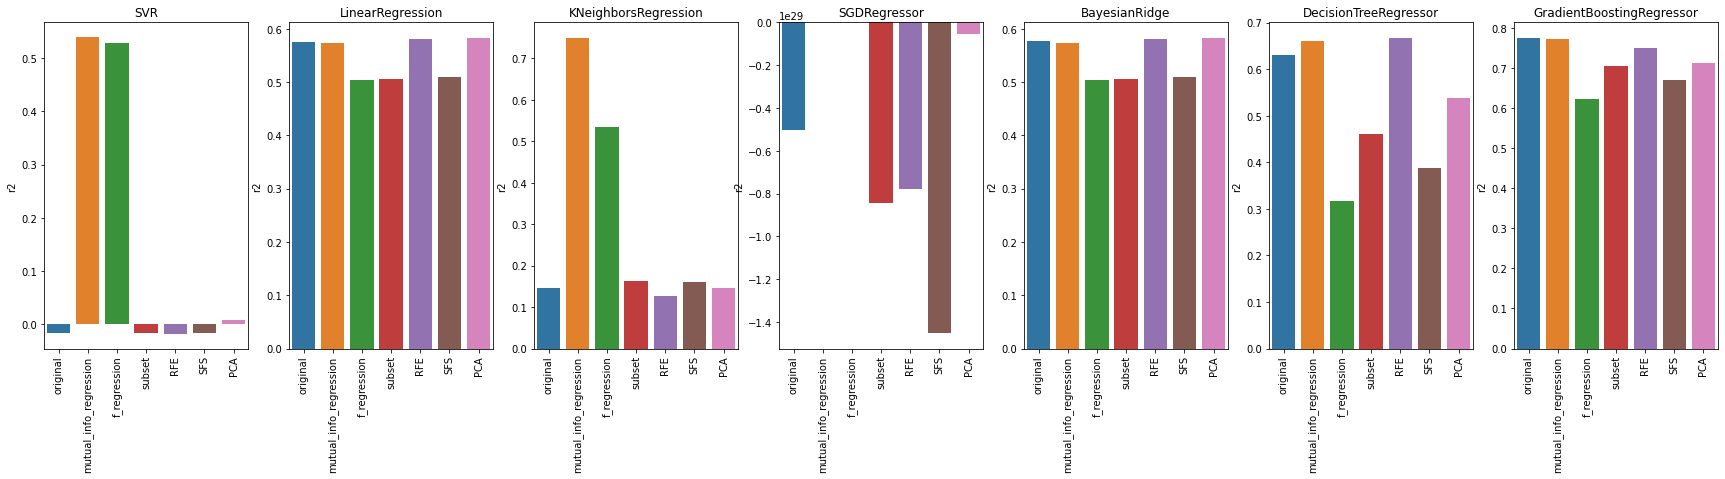

In [34]:
# subplot to show the results for each model
plt.figure(figsize=(30, 6))
for i, model in enumerate(models):
    plt.subplot(1, 7, i+1)
    sns.barplot(x="data_subset", y="r2", data=result[result["model"]==model[0]])
    plt.xlabel("")
    plt.title(model[0])
    plt.xticks(rotation=90)

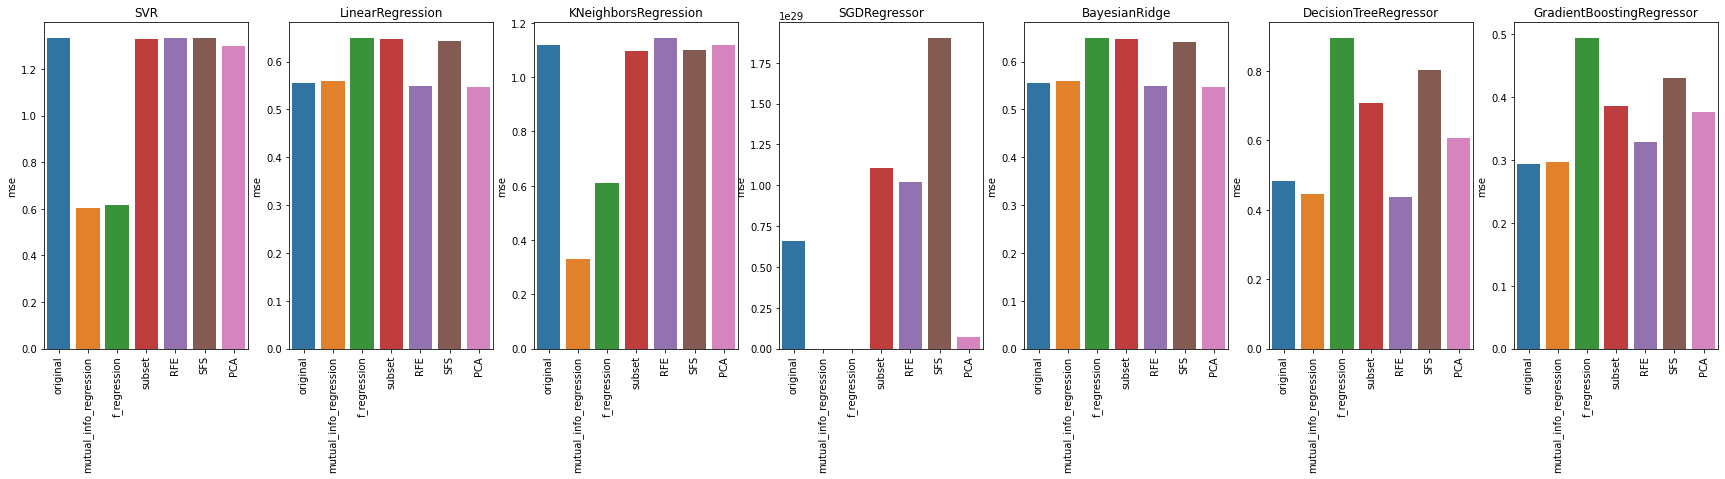

In [36]:
plt.figure(figsize=(30, 6))
for i, model in enumerate(models):
    plt.subplot(1, 7, i+1)
    sns.barplot(x="data_subset", y="mse", data=result[result["model"]==model[0]])
    plt.xlabel("")
    plt.title(model[0])
    plt.xticks(rotation=90)